In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

### 실습 데이터 - Credit Card Fraud Detection Data
- 데이터 설명 및 다운로드: https://www.kaggle.com/mlg-ulb/creditcardfraud
- 28개의 컬럼으로 구성
    - 28개의 변수(feature) 의미:  V1, V2, … V28은 PCA를 통해 얻은 주요 구성 요소입니다.
    - 다양한 데이터를 가지고 
- 특징 'Amount': 거래금액
- 특징 'Class': 응답 변수로 사기일 경우 값 1, 그렇지 않으면 값 0을 사용합니다.
$\to$ 타겟 기능, 클래스(0, 1; 이진분류)

In [3]:
data=pd.read_csv("./creditcard.csv")
data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


### 불필요한 데이터 제거

In [4]:
data=data.drop(['Time','Amount'],axis=1)
data.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0
284806,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,...,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,0


In [5]:
# 데이터 내 NA값 여부 확인
data.isnull() # NA 확인
data.isnull().any() # 만약 존재한다면 0으로 대체 혹은, 해당 열을 제외하고 진행

V1       False
V2       False
V3       False
V4       False
V5       False
V6       False
V7       False
V8       False
V9       False
V10      False
V11      False
V12      False
V13      False
V14      False
V15      False
V16      False
V17      False
V18      False
V19      False
V20      False
V21      False
V22      False
V23      False
V24      False
V25      False
V26      False
V27      False
V28      False
Class    False
dtype: bool


### 데이터 구조 확인

In [6]:
data.shape

(284807, 29)

In [7]:
data['V1']

0         -1.359807
1          1.191857
2         -1.358354
3         -0.966272
4         -1.158233
            ...    
284802   -11.881118
284803    -0.732789
284804     1.919565
284805    -0.240440
284806    -0.533413
Name: V1, Length: 284807, dtype: float64

In [8]:
data_feature = data.drop(['Class'], axis=1)

In [9]:
col_names = data_feature.columns

In [10]:
col_names

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')

### 데이터 분포 형태 확인

In [11]:
data_feature = data_feature[:10]

In [12]:
data_feature

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076


In [13]:
data_feature['V1'].max()

1.22965763450793

In [14]:
data_feature['V1'].min()

-1.3598071336738

In [15]:
data_feature

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076


In [16]:
data_feature['V1']

0   -1.359807
1    1.191857
2   -1.358354
3   -0.966272
4   -1.158233
5   -0.425966
6    1.229658
7   -0.644269
8   -0.894286
9   -0.338262
Name: V1, dtype: float64

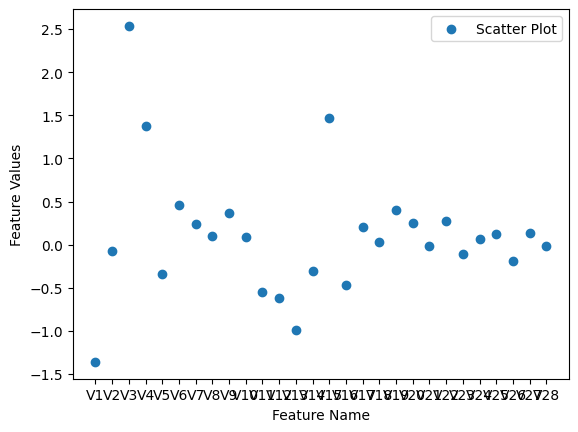

In [17]:
# 데이터 이해 및 시각화
plt.plot()
y = data_feature.iloc[0]
x = np.arange(len(y))
plt.scatter(x, y, label='Scatter Plot')
labels = data_feature.columns
plt.xticks(x, labels)
plt.xlabel('Feature Name')
plt.ylabel('Feature Values')
plt.legend()
plt.show()

### 데이터 기본 통계 확인 (Summary)

In [18]:
data.describe() 

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000


In [19]:
max(list(data.max()))

120.589493945238

In [20]:
min(list(data.min()))

-113.743306711146

### collection 패키지의 Counter 모듈을 이용해서 클래스 비율 확인
- 컨테이너에 동일한 값의 자료가 몇개인지를 파악하는데 사용하는 객체
- Class 불균형 정도 확인

In [21]:
# 타겟 변수(feature)의 분포 확인
from collections import Counter
class_count = Counter(data.Class)
print(class_count)
IR = class_count.get(0) / class_count.get(1) #응답 변수로 사기일 경우 값 1, 그렇지 않으면 값 0을 사용
print('IR (Class Imbalance Ratio): {}'.format(IR))

Counter({0: 284315, 1: 492})
IR (Class Imbalance Ratio): 577.8760162601626


### 각 변수별 특성 시각화 및 분석

In [22]:
data.loc[data['Class'] == 1] # class가 1인 Row 추출
# 개수 확인: 492 rows -> class 불균형한 상황

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,1
623,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1
4920,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,1
6108,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,1
6329,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,...,1.252967,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,1
280143,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.226138,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,1
280149,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.247968,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,1
281144,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,...,0.306271,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,1


<Figure size 640x480 with 0 Axes>

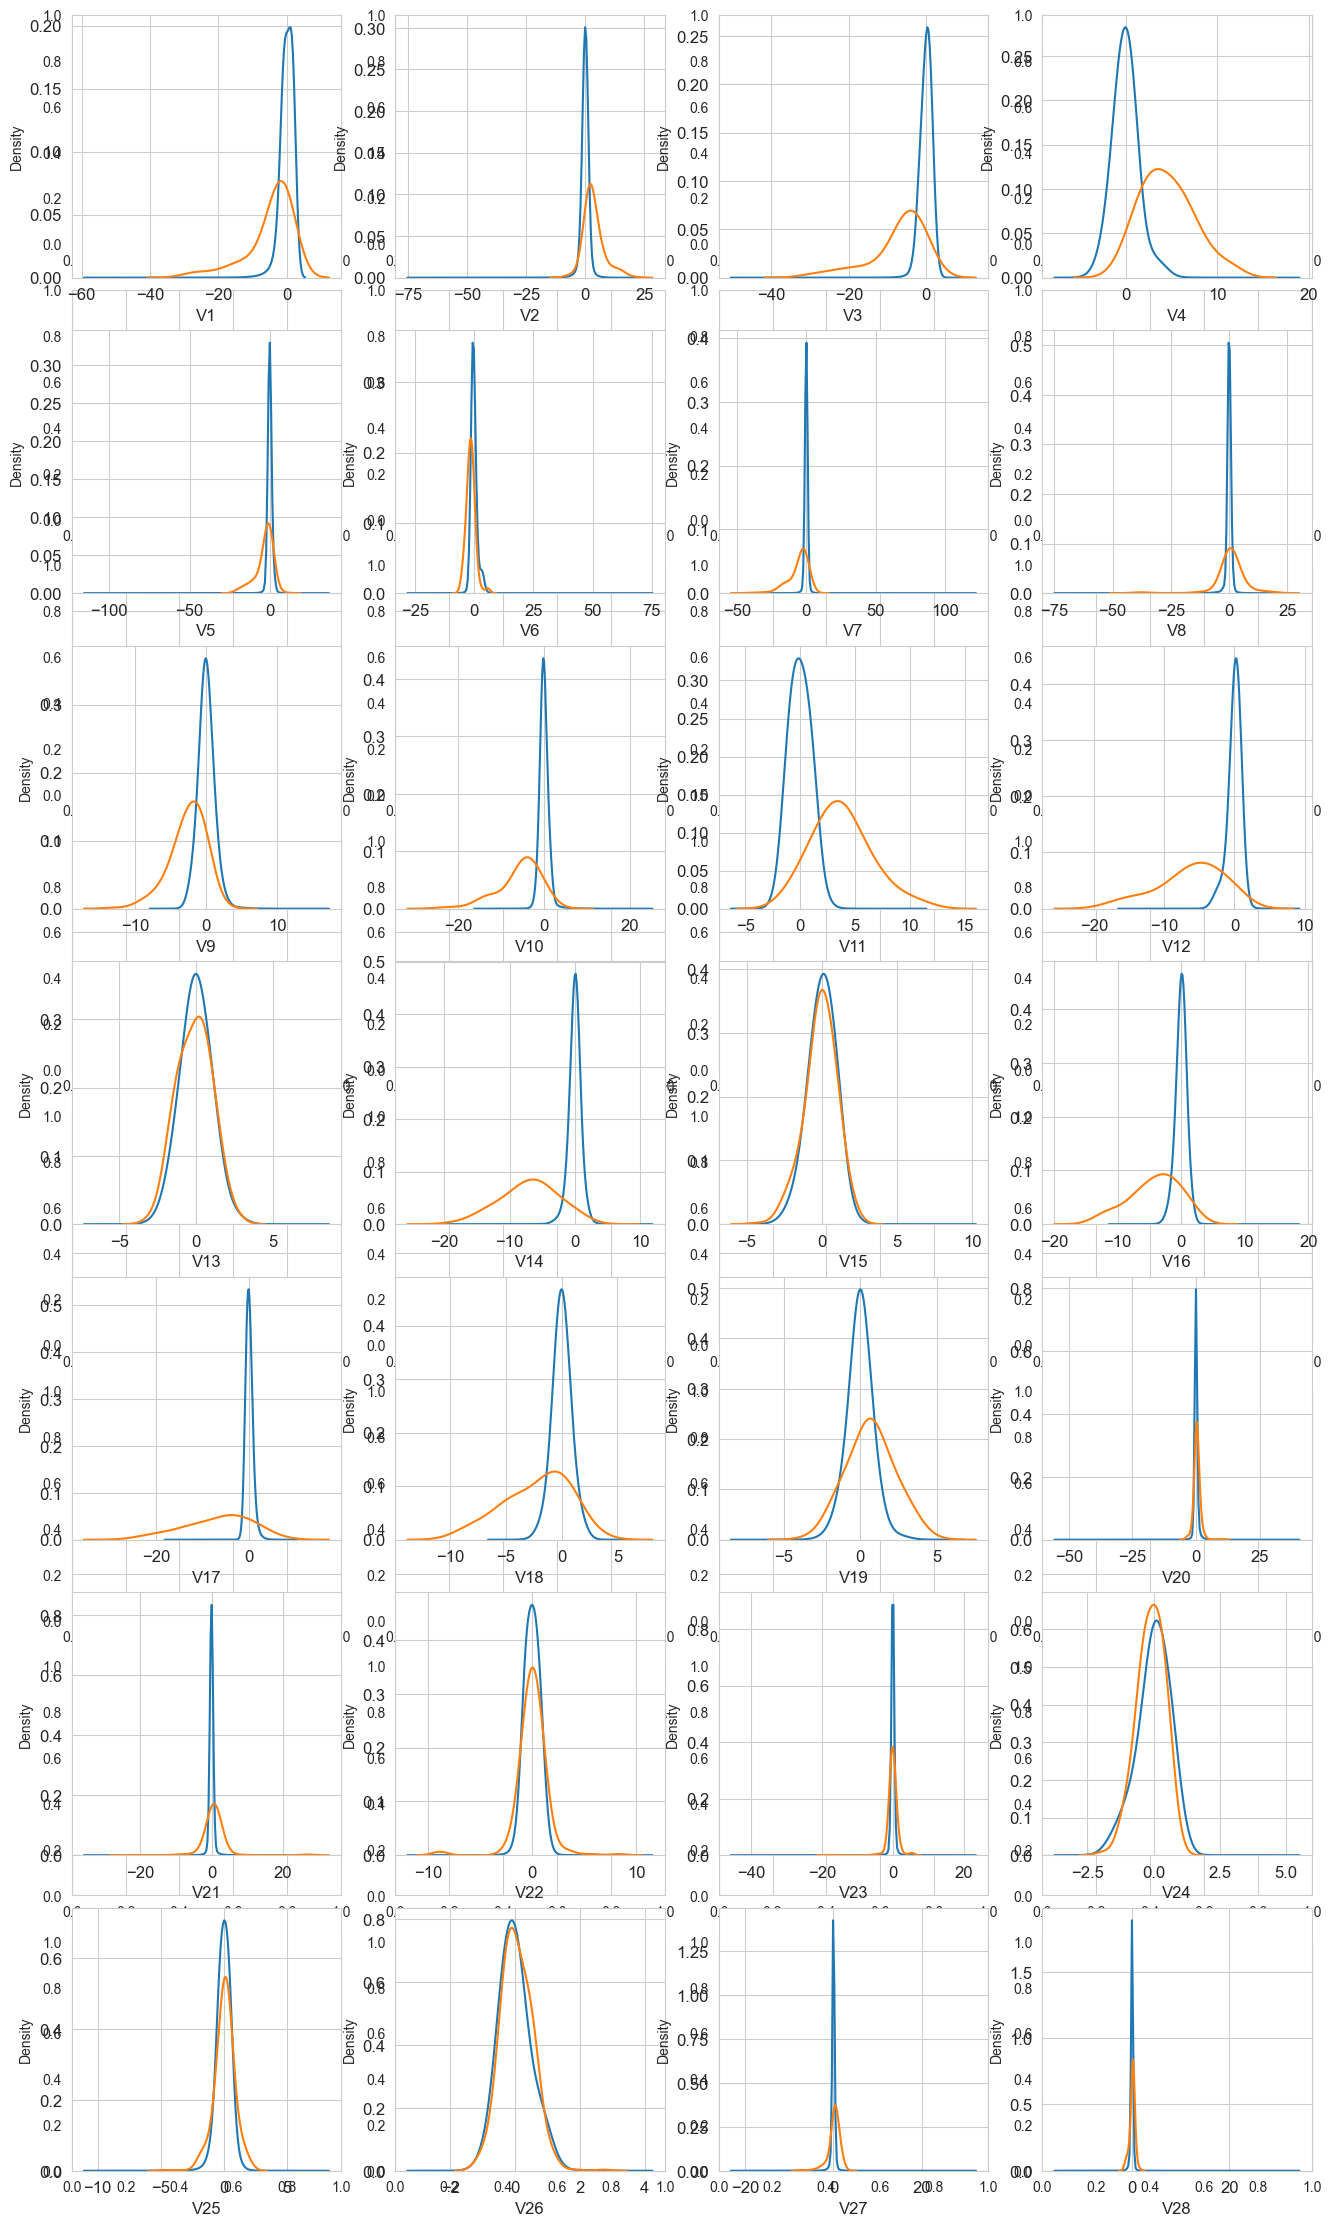

In [23]:
var = data.columns.values[:-1] # V1 ~ V28(Class열 제외한 모든 열)
i = 0
t0 = data.loc[data['Class'] == 0] # Class : 0 인 행만 추출 --> 정상 거리
t1 = data.loc[data['Class'] == 1] # Class : 1 인 행만 추출 --> 사기 거래

sns.set_style('whitegrid') # 그래프 스타일 지정
plt.figure()
fig, ax = plt.subplots(8, 4, figsize = (16, 28)) # 축 지정

# KDE Plot
# Kernel Desntiy Estimation is a non-parametric estimation of a PDF, 
# Probability Density Function of a random variable. 
# It's a smoothing process of a discontinuous PDF

for feature in var:
    i += 1
    plt.subplot(7, 4, i) # 28개의 그래프
    sns.kdeplot(t0[feature], bw_method = 0.5, label = "Class = 0")
    sns.kdeplot(t1[feature], bw_method = 0.5, label = "Class = 1")
    plt.xlabel(feature, fontsize = 12) # 라벨 속성값
    locs, labels = plt.xticks()
    plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show();

#### 각 변수 별 그래프를 타겟변수에 대해서 그려보았을 경우, 차이가 있는 변수들은 다음과 같이 정의할 수 있다.
- Plot의 모양을 보면서 직관석으로 해석
    - 타겟 변수에 대해 분포 차이가 많이 나는 변수 : V4, V11
    - 타겟 변수에 대해 분포 차이가 비교적 많이 존재하는 변수 : V12, V14, V18
    - 타겟 변수에 대해 분포 차이가 비교적 적게 존재하는 변수 : V1, V2, V3, V10
- Class 불균형한 상황을 생각해 보기
    - 비슷한 유형의 변수가 많다.
    - 특성을 명확히 구분할 수 있는 설명변수가 그리 많지 않다.
    - 이럴 경우 Over Sampling 수행 필요성을 곰곰히 생각해 본다.

c:\Users\MacBookPro\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


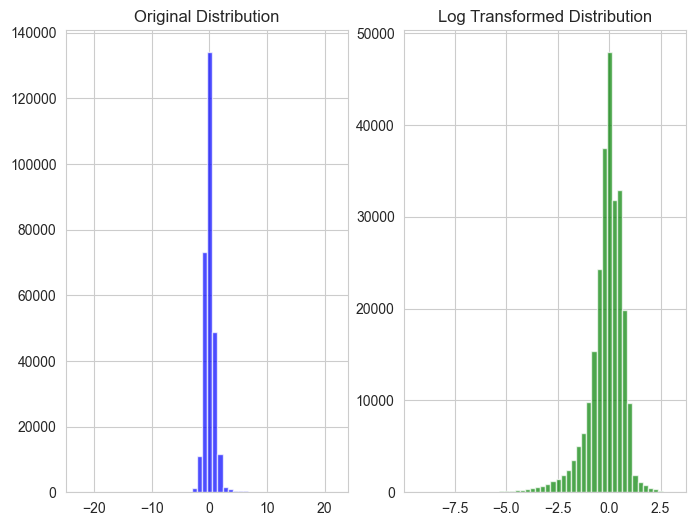

In [24]:
# 특성 스케일링 및 변환은 표준화를 사용하는 것이 적합
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 특성 데이터를 스케일링
scaled_features = scaler.fit_transform(data.drop('Class', axis=1))

# 스케일링된 데이터로 DataFrame 생성 (예시)
scaled_data = pd.DataFrame(data=scaled_features, columns=data.drop('Class', axis=1).columns)

# 스케일링된 데이터에 레이블 추가 (예시)
scaled_data['Class'] = data['Class']

# 로그 변환 적용 (표준화된 데이터에 적용하는 것을 예시로 보여줍니다)
log_scaled_data = np.log(1 + scaled_data.drop('Class', axis=1))

# 로그 변환 적용 후의 분포 시각화 예시 (한 개의 특성에 대해서만 시각화)
plt.figure(figsize=(8, 6))

# 로그 변환 전의 분포(예:V10)
plt.subplot(1, 2, 1)
plt.hist(scaled_data['V10'], bins=50, color='blue', alpha=0.7)
plt.title('Original Distribution')

# 로그 변환 후의 분포(예:V10)
plt.subplot(1, 2, 2)
plt.hist(log_scaled_data['V10'], bins=50, color='green', alpha=0.7)
plt.title('Log Transformed Distribution')

plt.show()

In [25]:
# 사용자 정의 변환기 클래스 생성
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        if self.columns is None:
            # 모든 열에 대해 로그 변환을 적용
            X_transformed = np.log1p(X_transformed)
        else:
            # 특정 열에 대해 로그 변환을 적용
            for col in self.columns:
                X_transformed[col] = np.log1p(X_transformed[col])
        return X_transformed

log_transformer = LogTransformer(columns=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                                          'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                                          'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'])
transformed_data = log_transformer.fit_transform(data)


c:\Users\MacBookPro\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:
# 변환 파이프라인
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# 파이프라인의 각 단계를 정의합니다.
numeric_features = data.columns.drop(['Class'])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # 결측치 대체
    ('scaler', StandardScaler())  # 표준화
])

# ColumnTransformer 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# 전체 파이프라인 정의
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# 파이프라인 시각화
set_config(display='diagram')
display(pipeline)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object'))]))])

In [27]:
X = np.array(data.iloc[:, data.columns != 'Class'])
y = np.array(data.iloc[:, data.columns == 'Class'])
X.shape, y.shape

((284807, 28), (284807, 1))

In [28]:
#학습데이터와 테스트데이터를 분리합니다
#학습데이터 80% 테스트데이터 20%로 설정합니다
#알고리즘별 학습결과를 비교하기 위해 random state를 0으로 설정합니다
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (227845, 28)
Number transactions y_train dataset:  (227845, 1)
Number transactions X_test dataset:  (56962, 28)
Number transactions y_test dataset:  (56962, 1)


In [29]:
# 모델 성능평가 함수를 미리 만들어 놓기
# 이 함수는 confusion matrix(혼동 행렬)을 기반으로 정확도(Accuracy), 정밀도(Precision), 재현율(Recall), F1 스코어(F1-Score)를 계산하고 출력합니다.
def model_evaluation(label, predict):
    cf_matrix = confusion_matrix(label, predict)
    Accuracy = (cf_matrix[0][0] + cf_matrix[1][1]) / sum(sum(cf_matrix))
    Precision = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[0][1])
    Recall = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[1][0])
    F1_Score = (2 * Recall * Precision) / (Recall + Precision)
    print("Model_Evaluation with Label:1")
    print("Accuracy: ", Accuracy)
    print("Precision: ", Precision)
    print("Recall: ", Recall)
    print("F1-Score: ", F1_Score)

# Light GBM을 기본 모델로 설정

In [30]:
lgb_dtrain = lgb.Dataset(data = pd.DataFrame(X_train), label = pd.DataFrame(y_train)) # 학습 데이터를 LightGBM 모델에 맞게 변환
lgb_param = {'max_depth': 10, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 50, # Number of trees, 트리 생성 개수
            'objective': 'binary'} # 파라미터 추가, Label must be in [0, num_class) -> num_class보다 1 커야한다.
lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
pred= np.repeat(0, len(y_test))
pred[lgb_model.predict(X_test) > 0.5] = 1
model_evaluation(y_test, pred)

#모델 평가 결과에 대한 설명:
#정확도 (Accuracy): 99.92%로 매우 높은 정확도를 보입니다. 그러나, 이 데이터는 신용카드 사기 탐지와 같은 불균형한 클래스 분포를 가지고 있기 때문에 정확도만으로 모델의 성능을 평가하는 것은 적절하지 않을 수 있습니다.
#정밀도 (Precision): 92.19%로 매우 높습니다. 정밀도는 모델이 사기 거래라고 예측한 경우 중에서 실제로 사기 거래인 비율을 나타냅니다. 높은 정밀도는 모델이 정상 거래를 사기 거래로 잘못 분류하는 경우가 적다는 것을 의미합니다.
#재현율 (Recall): 58.42%로 중간 정도입니다. 재현율은 실제 사기 거래 중에서 모델이 정확하게 감지한 비율을 나타냅니다. 중간 정도의 재현율은 실제 사기 거래를 놓치는 경우가 있다는 것을 의미합니다.
#F1 스코어 (F1-Score): 71.52%로 중간 정도입니다. F1 스코어는 정밀도와 재현율의 조화 평균으로, 두 지표가 균형을 이룰 때 높은 값을 갖습니다. 중간 정도의 F1 스코어는 모델의 정밀도와 재현율이 균형을 이루고 있다는 것을 나타냅니다.
#이 평가 지표 결과를 통해 모델은 사기 거래를 잘 감지할 수 있지만, 그 중에서도 일부 정상 거래를 사기 거래로 잘못 예측하는 경우가 있다는 것을 알 수 있습니다. 
#클래스 불균형 문제에 대응하기 위해 리샘플링 기법이나 다양한 평가 지표를 사용하여 모델을 튜닝하고 평가해볼 필요가 있습니다.

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


c:\Users\MacBookPro\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 391, number of negative: 227454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001716 -> initscore=-6.365996
[LightGBM] [Info] Start training from score -6.365996
Model_Evaluation with Label:1
Accuracy:  0.9991748885221726
Precision:  0.921875
Recall:  0.5841584158415841
F1-Score:  0.7151515151515151


# 클래스 불균형 문제를 해결하기 위해 Oversampling을 수행
- 추가 성능향상이 가능한지 확인

In [31]:
# 기존 데이터 구조 재확인
print("X_train dataset: ", X_train.shape)
print("y_train dataset: ", y_train.shape)
print("X_test dataset: ", X_test.shape)
print("y_test dataset: ", y_test.shape)

X_train dataset:  (227845, 28)
y_train dataset:  (227845, 1)
X_test dataset:  (56962, 28)
y_test dataset:  (56962, 1)


## imblearn 설치

In [32]:
!pip3 install imblearn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
from imblearn.over_sampling import SMOTE

print("SMOTE 수행 이전 label '1' 개수: {}".format(sum(y_train == 1))) # y_train 중 레이블 값이 1인 데이터의 개수
print("SMOTE 수행 이전 label '0' 개수: {} \n".format(sum(y_train == 0))) # y_train 중 레이블 값이 0 인 데이터의 개수

sm = SMOTE(random_state=0, sampling_strategy=0.3) # SMOTE 알고리즘, 샘플링 비율 증가('1' 클래스의 데이터를 30배로 증가)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel()) # Over Sampling 진행

print("SMOTE 수행 결과 label '1' 개수: {}".format(sum(y_train_res==1)))
print("SMOTE 수행 결과 label '0' 개수': {}".format(sum(y_train_res==0)))



SMOTE 수행 이전 label '1' 개수: [391]
SMOTE 수행 이전 label '0' 개수: [227454] 

SMOTE 수행 결과 label '1' 개수: 68236
SMOTE 수행 결과 label '0' 개수': 227454


In [34]:
print("SMOTE 수행 이전 X_train: {}".format(X_train.shape)) # SMOTE 적용 이전 데이터 형태
print("SMOTE 수행 이전 y_train: {}".format(y_train.shape)) # SMOTE 적용 이전 데이터 형태
print('SMOTE 수행 결과 X_train: {}'.format(X_train_res.shape)) # SMOTE 적용 결과 확인
print('SMOTE 수행 결과 y_train: {}'.format(y_train_res.shape)) # # SMOTE 적용 결과 확인

SMOTE 수행 이전 X_train: (227845, 28)
SMOTE 수행 이전 y_train: (227845, 1)
SMOTE 수행 결과 X_train: (295690, 28)
SMOTE 수행 결과 y_train: (295690,)


## 동일한 코드를 이용하여 LightGBM 다시 수행 후 성능향상 확인
- 위에서 사용한 코드 그대로 복사 -> 붙여넣기 
- 입력값만 달라짐
- SMOTE 전.후 성능지표를 비교
    - 만약 성능이 향상된다면
    - 클래스 불균형이 Over Sampling으로 어느정도 극복된 것으로 판단.

In [35]:
lgb_dtrain2 = lgb.Dataset(data = pd.DataFrame(X_train_res), label = pd.DataFrame(y_train_res)) # 학습 데이터를 LightGBM 모델에 맞게 변환
lgb_param2 = {'max_depth': 10, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 50, # Number of trees, 트리 생성 개수
            'objective': 'multiclass', # 목적 함수
            'num_class': len(set(pd.DataFrame(y_train_res))) + 1} # 파라미터 추가, Label must be in [0, num_class) -> num_class보다 1 커야한다.
lgb_model2 = lgb.train(params = lgb_param2, train_set = lgb_dtrain2) # 학습 진행
lgb_model2_predict = np.argmax(lgb_model2.predict(X_test), axis = 1) # 평가 데이터 예측, Softmax의 결과값 중 가장 큰 값의 Label로 예측
model_evaluation(y_test, lgb_model2_predict) # 모델 분류 평가 결과

#모델 평가 결과에 대한 설명:
#정확도 (Accuracy): 99.91%로 매우 높은 정확도를 보입니다. 그러나, 이 데이터는 신용카드 사기 탐지와 같은 불균형한 클래스 분포를 가지고 있기 때문에 정확도만으로 모델의 성능을 평가하는 것은 적절하지 않을 수 있습니다.
#정밀도 (Precision): 71.07%로 중간 정도입니다. 정밀도는 모델이 사기 거래라고 예측한 경우 중에서 실제로 사기 거래인 비율을 나타냅니다. 이 모델은 사기 거래로 예측한 경우 중에 약 71%만이 실제로 사기 거래입니다.
#재현율 (Recall): 85.15%로 높습니다. 재현율은 실제 사기 거래 중에서 모델이 정확하게 감지한 비율을 나타냅니다. 높은 재현율은 실제 사기 거래를 놓치는 경우가 적다는 것을 의미합니다.
#F1 스코어 (F1-Score): 77.48%로 높습니다. F1 스코어는 정밀도와 재현율의 조화 평균으로, 두 지표가 균형을 이룰 때 높은 값을 갖습니다. 높은 F1 스코어는 모델의 정밀도와 재현율이 균형을 이루고 있다는 것을 나타냅니다.
#이 평가 지표 결과를 통해 모델은 사기 거래를 잘 감지하고 있으며, 그 중에서도 대부분의 사기 거래를 식별할 수 있습니다. 하지만 여전히 약간의 과격한 예측이 있을 수 있으므로, 비즈니스 상황에 따라 재현율과 정밀도의 균형을 조절할 필요가 있을 것입니다.

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


c:\Users\MacBookPro\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 295690, number of used features: 28
[LightGBM] [Info] Start training from score -0.262364
[LightGBM] [Info] Start training from score -1.466339
Model_Evaluation with Label:1
Accuracy:  0.9991222218320986
Precision:  0.7107438016528925
Recall:  0.8514851485148515
F1-Score:  0.7747747747747747


# Over sampling이 통한다면...
## 그렇다면, Oversampling 크기를 증가시킨다면? (30% $\to$ 60%)
- 성능 변화를 직접 확인

In [36]:
print("SMOTE 수행 이전 label '1' 개수: {}".format(sum(y_train == 1))) # y_train 중 레이블 값이 1인 데이터의 개수
print("SMOTE 수행 이전 label '0' 개수: {} \n".format(sum(y_train == 0))) # y_train 중 레이블 값이 0 인 데이터의 개수

sm2 = SMOTE(random_state = 0, sampling_strategy=0.6) # SMOTE 알고리즘, 샘플링 비율 증가('1' 클래스의 데이터를 60배로 증가)
X_train_res2, y_train_res2 = sm2.fit_resample(X_train, y_train.ravel()) # Over Sampling 진행

print("SMOTE 수행 결과 label '1' 개수: {}".format(sum(y_train_res2==1)))
print("SMOTE 수행 결과 label '0' 개수: {}".format(sum(y_train_res2==0)))

SMOTE 수행 이전 label '1' 개수: [391]
SMOTE 수행 이전 label '0' 개수: [227454] 

SMOTE 수행 결과 label '1' 개수: 136472
SMOTE 수행 결과 label '0' 개수: 227454


In [37]:
lgb_dtrain3 = lgb.Dataset(data = pd.DataFrame(X_train_res2), label = pd.DataFrame(y_train_res2)) # 학습 데이터를 LightGBM 모델에 맞게 변환
lgb_param3 = {'max_depth': 10, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 50, # Number of trees, 트리 생성 개수
            'objective': 'multiclass', # 목적 함수
            'num_class': len(set(pd.DataFrame(y_train_res2))) + 1} # 파라미터 추가, Label must be in [0, num_class) -> num_class보다 1 커야한다.
lgb_model3 = lgb.train(params = lgb_param3, train_set = lgb_dtrain3) # 학습 진행
lgb_model3_predict = np.argmax(lgb_model3.predict(X_test), axis = 1) # 평가 데이터 예측, Softmax의 결과값 중 가장 큰 값의 Label로 예측
model_evaluation(y_test, lgb_model3_predict) # 모델 분류 평가 결과

#모델 평가 결과에 대한 설명:
#정확도 (Accuracy): 99.42%로 매우 높은 정확도를 보입니다. 그러나, 이 데이터는 신용카드 사기 탐지와 같은 불균형한 클래스 분포를 가지고 있기 때문에 정확도만으로 모델의 성능을 평가하는 것은 적절하지 않을 수 있습니다.
#정밀도 (Precision): 21.67%로 비교적 낮습니다. 정밀도는 모델이 사기 거래라고 예측한 경우 중에서 실제로 사기 거래인 비율을 나타냅니다. 이 모델은 사기 거래로 예측한 경우 중에 약 22%만이 실제로 사기 거래입니다.
#재현율 (Recall): 87.13%로 높습니다. 재현율은 실제 사기 거래 중에서 모델이 정확하게 감지한 비율을 나타냅니다. 높은 재현율은 실제 사기 거래를 놓치는 경우가 적다는 것을 의미합니다.
#F1 스코어 (F1-Score): 34.71%로 중간 정도입니다. F1 스코어는 정밀도와 재현율의 조화 평균으로, 두 지표가 균형을 이룰 때 높은 값을 갖습니다. 이 모델의 F1 스코어는 두 지표가 균형을 이루고 있음을 나타냅니다.
#이 평가 지표 결과를 통해 모델은 사기 거래를 상당히 잘 감지하고 있으며, 그 중에서도 대부분의 사기 거래를 식별할 수 있습니다. 그러나, 정밀도가 낮기 때문에 실제 사기가 아닌 거래를 사기로 잘못 분류하는 경우가 있을 수 있습니다. 
#이 모델을 사용할 때에는 비즈니스 요구사항에 따라 재현율과 정밀도의 균형을 조절해야 할 것입니다.

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


c:\Users\MacBookPro\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 363926, number of used features: 28
[LightGBM] [Info] Start training from score -0.470003
[LightGBM] [Info] Start training from score -0.980831
Model_Evaluation with Label:1
Accuracy:  0.9941891085284926
Precision:  0.21674876847290642
Recall:  0.8712871287128713
F1-Score:  0.34714003944773175


# 극단적인 경우 테스트 (100%)
- 1:1 비율로 Oversampling
- 수행 결과를 30%, 60% 경우의 성능지표와 비교

In [38]:
print("SMOTE 수행 이전 label '1' 개수: {}".format(sum(y_train == 1))) # y_train 중 레이블 값이 1인 데이터의 개수
print("SMOTE 수행 이전 label '0' 개수: {} \n".format(sum(y_train == 0))) # y_train 중 레이블 값이 0 인 데이터의 개수

sm3 = SMOTE(random_state = 0) # SMOTE 알고리즘, Default: 동등
X_train_res3, y_train_res3 = sm3.fit_resample(X_train, y_train.ravel()) # Over Sampling 진행

print("SMOTE 수행 결과 label '1' 개수: {}".format(sum(y_train_res3==1)))
print("SMOTE 수행 결과 label '0' 개수: {}".format(sum(y_train_res3==0)))

SMOTE 수행 이전 label '1' 개수: [391]
SMOTE 수행 이전 label '0' 개수: [227454] 

SMOTE 수행 결과 label '1' 개수: 227454
SMOTE 수행 결과 label '0' 개수: 227454


In [43]:
lgb_dtrain4 = lgb.Dataset(data = pd.DataFrame(X_train_res3), label = pd.DataFrame(y_train_res3)) # 학습 데이터를 LightGBM 모델에 맞게 변환
lgb_param4 = {'max_depth': 10, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 50, # Number of trees, 트리 생성 개수
            'objective': 'multiclass', # 목적 함수
            'num_class': len(set(pd.DataFrame(y_train_res3))) + 1} # 파라미터 추가, Label must be in [0, num_class) -> num_class보다 1 커야한다.
lgb_model4 = lgb.train(params = lgb_param4, train_set = lgb_dtrain4) # 학습 진행
lgb_model4_predict = np.argmax(lgb_model4.predict(X_test), axis = 1) # 평가 데이터 예측, Softmax의 결과값 중 가장 큰 값의 Label로 예측
model_evaluation(y_test, lgb_model4_predict) # 모델 분류 평가 결과

#모델 평가 결과에 대한 설명:
#정확도 (Accuracy): 98.34%로 높은 정확도를 보입니다. 그러나, 이 데이터는 신용카드 사기 탐지와 같은 불균형한 클래스 분포를 가지고 있기 때문에 정확도만으로 모델의 성능을 평가하는 것은 적절하지 않을 수 있습니다.
#정밀도 (Precision): 8.64%로 매우 낮습니다. 정밀도는 모델이 사기 거래라고 예측한 경우 중에서 실제로 사기 거래인 비율을 나타냅니다. 이 모델은 사기 거래로 예측한 경우 중에 약 8.64%만이 실제로 사기 거래입니다.
#재현율 (Recall): 87.13%로 높습니다. 재현율은 실제 사기 거래 중에서 모델이 정확하게 감지한 비율을 나타냅니다. 높은 재현율은 실제 사기 거래를 놓치는 경우가 적다는 것을 의미합니다.
#F1 스코어 (F1-Score): 15.73%로 매우 낮습니다. F1 스코어는 정밀도와 재현율의 조화 평균으로, 두 지표가 균형을 이룰 때 높은 값을 갖습니다. 이 모델의 F1 스코어가 낮다는 것은 정밀도와 재현율이 불균형하게 평가되고 있다는 것을 나타냅니다.
#이 평가 지표 결과를 통해 이 모델은 실제 사기 거래를 잘 감지하지만, 대부분의 정확도는 실제로 사기가 아닌 거래를 사기로 잘못 분류하고 있습니다. 이 모델을 실제 환경에서 사용할 때에는 정밀도와 재현율의 균형을 맞추는 것이 중요할 것입니다.

c:\Users\MacBookPro\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 454908, number of used features: 28
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Start training from score -0.693147
Model_Evaluation with Label:1
Accuracy:  0.9834451037533795
Precision:  0.08644400785854617
Recall:  0.8712871287128713
F1-Score:  0.1572832886505809


## 다양한 실험 결과 $\to$ 결론: 30%가 가장 적합